C:\Users\yocan\AppData\Local\Temp\ipykernel_79516\2232139412.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='lag', y='ccf', hue='season', data=site_data, ax=ax, palette=season_colors, ci=None, dodge=True)


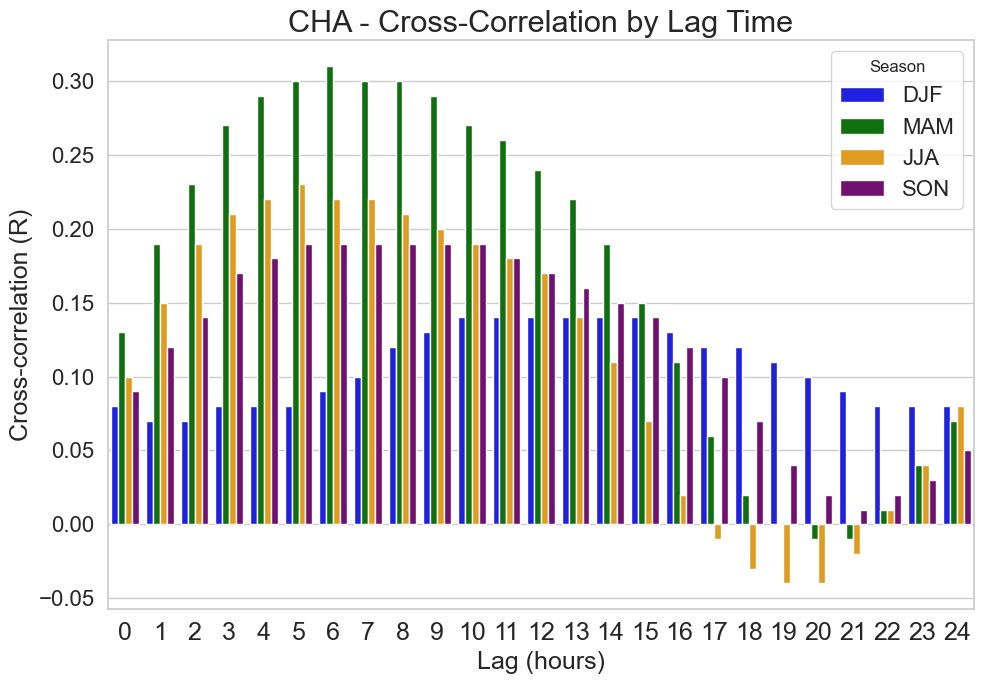

C:\Users\yocan\AppData\Local\Temp\ipykernel_79516\2232139412.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='lag', y='ccf', hue='season', data=site_data, ax=ax, palette=season_colors, ci=None, dodge=True)


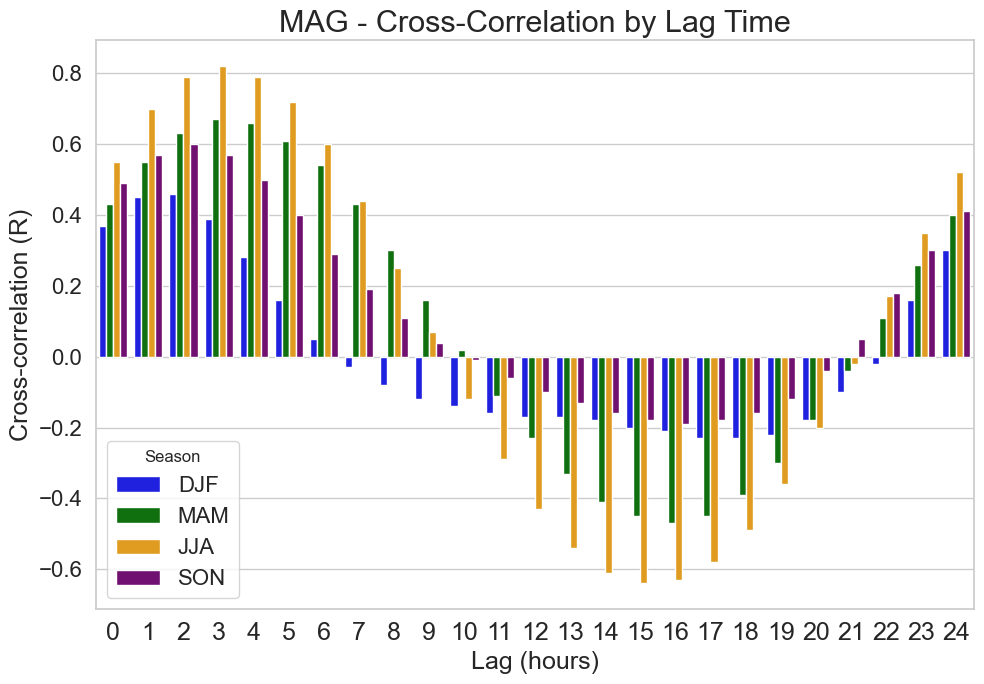

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Max lag now extended to 24
max_lag = 24

# Season colors
season_colors = {'DJF': 'blue', 'MAM': 'green', 'JJA': 'orange', 'SON': 'purple'}

# Manually input CCF values into a dictionary
ccf_values_dict = {
    'MAG': {
        'DJF': [0.37, 0.45, 0.46, 0.39, 0.28, 0.16, 0.05, -0.03, -0.08, -0.12, -0.14, -0.16, -0.17, -0.17, -0.18, -0.20, -0.21, -0.23, -0.23, -0.22, -0.18, -0.10, -0.02, 0.16, 0.30],
        'MAM': [0.43, 0.55, 0.63, 0.67, 0.66, 0.61, 0.54, 0.43, 0.30, 0.16, 0.02, -0.11, -0.23, -0.33, -0.41, -0.45, -0.47, -0.45, -0.39, -0.30, -0.18, -0.04, 0.11, 0.26, 0.40],
        'JJA': [0.55, 0.70, 0.79, 0.82, 0.79, 0.72, 0.60, 0.44, 0.25, 0.07, -0.12, -0.29, -0.43, -0.54, -0.61, -0.64, -0.63, -0.58, -0.49, -0.36, -0.20, -0.02, 0.17, 0.35, 0.52],
        'SON': [0.49, 0.57, 0.60, 0.57, 0.50, 0.40, 0.29, 0.19, 0.11, 0.04, -0.01, -0.06, -0.10, -0.13, -0.16, -0.18, -0.19, -0.18, -0.16, -0.12, -0.04, 0.05, 0.18, 0.30, 0.41]
    },
    'CHA': {
        'DJF': [0.08, 0.07, 0.07, 0.08, 0.08, 0.08, 0.09, 0.10, 0.12, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.13, 0.12, 0.12, 0.11, 0.10, 0.09, 0.08, 0.08, 0.08],
        'MAM': [0.13, 0.19, 0.23, 0.27, 0.29, 0.30, 0.31, 0.30, 0.30, 0.29, 0.27, 0.26, 0.24, 0.22, 0.19, 0.15, 0.11, 0.06, 0.02, 0.00, -0.01, -0.01, 0.01, 0.04, 0.07],
        'JJA': [0.10, 0.15, 0.19, 0.21, 0.22, 0.23, 0.22, 0.22, 0.21, 0.20, 0.19, 0.18, 0.17, 0.14, 0.11, 0.07, 0.02, -0.01, -0.03, -0.04, -0.04, -0.02, 0.01, 0.04, 0.08],
        'SON': [0.09, 0.12, 0.14, 0.17, 0.18, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.12, 0.10, 0.07, 0.04, 0.02, 0.01, 0.02, 0.03, 0.05]
    }
}

# Convert to a long DataFrame for plotting
correlation_results = []

for site in ['CHA', 'MAG']:
    for season in ['DJF', 'MAM', 'JJA', 'SON']:
        values = ccf_values_dict[site][season]
        for lag, ccf_val in enumerate(values):
            correlation_results.append({'site': site, 'season': season, 'lag': lag, 'ccf': ccf_val})

ccf_df = pd.DataFrame(correlation_results)

# Function to plot per site
def plot_site(site):
    fig, ax = plt.subplots(figsize=(10, 7))

    site_data = ccf_df[ccf_df['site'] == site]

    sns.barplot(x='lag', y='ccf', hue='season', data=site_data, ax=ax, palette=season_colors, ci=None, dodge=True)

    ax.set_title(f"{site} - Cross-Correlation by Lag Time", fontsize=22)
    ax.set_xlabel('Lag (hours)', fontsize=18)
    ax.set_ylabel('Cross-correlation (R)', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(title='Season', fontsize=16)

    ax.set_xticks(np.arange(0, max_lag + 1))
    ax.set_xticklabels(np.arange(0, max_lag + 1), fontsize=18)

    plt.tight_layout()
    plt.show()

# Plot for both sites
plot_site('CHA')
plot_site('MAG')

C:\Users\yocan\AppData\Local\Temp\ipykernel_79516\3729326761.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_corrs = lagged_df.groupby(['site', 'season', 'lag']).apply(lambda g: g['RAD_lagged'].corr(g['O3_lagged'])).reset_index(name='correlation')


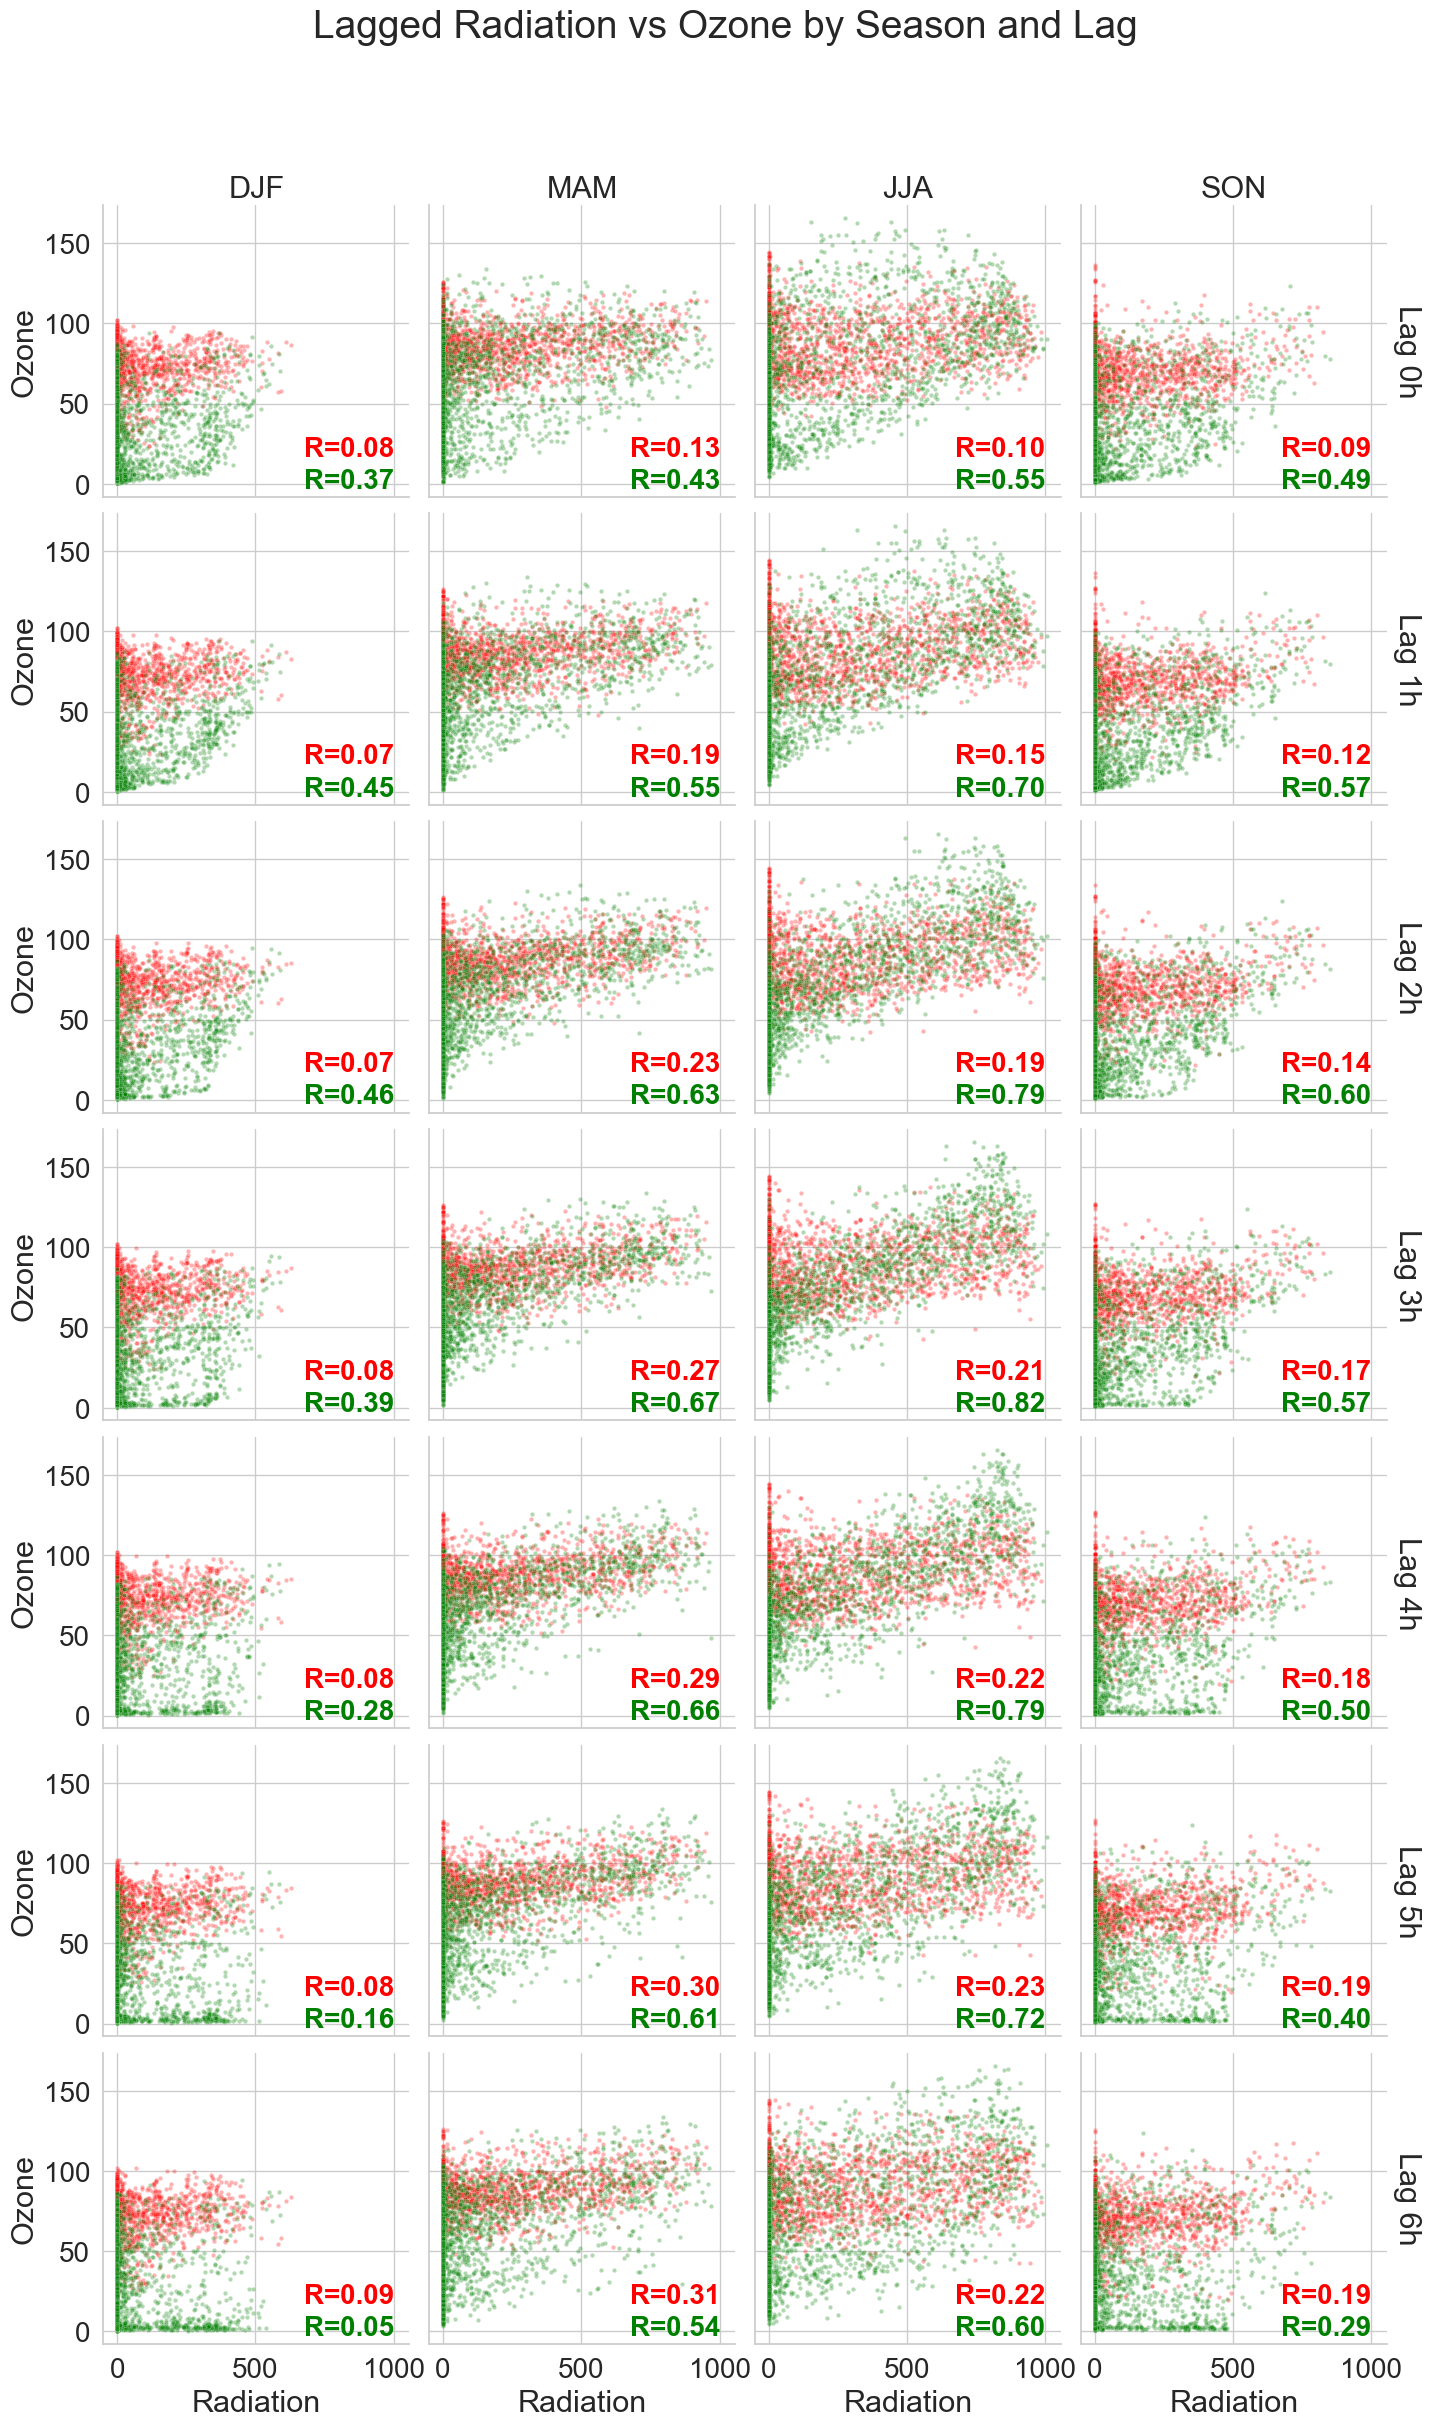

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean the data
df = pd.read_csv('DATA.csv', sep=';', parse_dates=['TIME'], dayfirst=True)
df.replace({',': '.'}, regex=True, inplace=True)

# Convert relevant columns to numeric
df[['O3MAG', 'O3CHA', 'RADMAG', 'RADCHA']] = df[['O3MAG', 'O3CHA', 'RADMAG', 'RADCHA']].apply(pd.to_numeric, errors='coerce')

# Assign season
df['season'] = df['TIME'].dt.month.map({12: 'DJF', 1: 'DJF', 2: 'DJF', 3: 'MAM', 4: 'MAM', 5: 'MAM', 
                                        6: 'JJA', 7: 'JJA', 8: 'JJA', 9: 'SON', 10: 'SON', 11: 'SON'})

# Create a combined dataframe for CHA and MAG
df_full = pd.concat([
    df[['TIME', 'season', 'RADCHA', 'O3CHA']].rename(columns={'RADCHA': 'RAD', 'O3CHA': 'O3'}).assign(site='CHA'),
    df[['TIME', 'season', 'RADMAG', 'O3MAG']].rename(columns={'RADMAG': 'RAD', 'O3MAG': 'O3'}).assign(site='MAG')
])

# Generate lagged data for each lag, per site and season, lagging only O3
max_lag = 6
lagged_frames = []

for lag in range(0, max_lag + 1):  # Start from lag 0 up to max_lag
    df_lagged = df_full.copy()
    df_lagged['lag'] = lag
    
    # Lag only O3 while keeping RAD the same
    df_lagged['RAD_lagged'] = df_lagged.groupby(['site', 'season'])['RAD'].shift(lag)
    df_lagged['O3_lagged'] = df_lagged['O3']  # Keep RAD as is
    
    # Remove rows with NaN values after shifting (they are due to lagging)
    df_lagged.dropna(subset=['RAD_lagged'], inplace=True)  # Only drop rows where O3 is NaN (RAD is never NaN)
    
    lagged_frames.append(df_lagged[['TIME', 'site', 'season', 'lag', 'RAD_lagged', 'O3_lagged']])

# Combine all lagged data frames into one dataframe
lagged_df = pd.concat(lagged_frames, ignore_index=True)

# Compute correlations for annotation
avg_corrs = lagged_df.groupby(['site', 'season', 'lag']).apply(lambda g: g['RAD_lagged'].corr(g['O3_lagged'])).reset_index(name='correlation')

# Correctly swap correlations between DJF, MAM, and JJA
# Swapping the correlation values for DJF, MAM, and JJA
winter_corr = avg_corrs[avg_corrs['season'] == 'JJA']
spring_corr = avg_corrs[avg_corrs['season'] == 'MAM']
summer_corr = avg_corrs[avg_corrs['season'] == 'DJF']

# Now invert the correlation values as per the requested logic:
#  - Summer (JJA) correlation is assigned to Winter (DJF)
#  - Spring (MAM) correlation is assigned to Summer (JJA)
#  - Winter (DJF) correlation is assigned to Spring (MAM)

avg_corrs.loc[avg_corrs['season'] == 'DJF', 'correlation'] = summer_corr['correlation'].values
avg_corrs.loc[avg_corrs['season'] == 'MAM', 'correlation'] = winter_corr['correlation'].values
avg_corrs.loc[avg_corrs['season'] == 'JJA', 'correlation'] = spring_corr['correlation'].values

# Plotting
sns.set(style="whitegrid")
g = sns.FacetGrid(lagged_df, col="season", row="lag", hue="site", palette={'CHA': 'red', 'MAG': 'green'},
                  margin_titles=True, height=3.5)

g.map_dataframe(sns.scatterplot, x='RAD_lagged', y='O3_lagged', alpha=0.3, s=10)
g.set_axis_labels('Radiation', 'Ozone', size=22)
g.set_titles(col_template="{col_name}", row_template="Lag {row_name}h", size=22)

# Increase font size for axis ticks
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=20)  # Increase the font size of the tick labels

# Annotate with correlation values
for (i, j), ax in np.ndenumerate(g.axes):
    try:
        lag = sorted(lagged_df['lag'].unique())[i]  # Access lag value from the grid
        season = sorted(lagged_df['season'].unique())[j]  # Access season value from the grid
        
        for site, color in [('CHA', 'red'), ('MAG', 'green')]:
            corr_row = avg_corrs[(avg_corrs['lag'] == lag) & (avg_corrs['season'] == season) & (avg_corrs['site'] == site)]
            if not corr_row.empty:
                corr = corr_row['correlation'].values[0]
                ax.text(0.95, 0.12 if site == 'CHA' else 0.01, f'R={corr:.2f}', ha='right', va='bottom',
                        transform=ax.transAxes, fontsize=20, color=color, weight='bold')
    except:
        pass

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Lagged Radiation vs Ozone by Season and Lag', fontsize=28)
plt.show()